## Functions and libraries

In [149]:
import pandas as pd
from pathlib import Path
path = Path('/mnt/research-live/equity/reference/equity_data/sa_research/current/')
import pandas as pd 
import numpy as np 
import faiss 
import re
import tqdm
import torch 
import torch.nn.functional as F
import dill as pickle
import datetime
import plotly.express as px
from laserembeddings import Laser
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import copy
import math
from scipy.signal import find_peaks
import seaborn as sns
from pandas.tseries.offsets import BDay
from sklearn.metrics import silhouette_score
from sklearn import metrics
from time import time
from sklearn.cluster import KMeans

In [150]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [151]:
def plot_month_bar(df, y_col,earning_days=False):
    df['date'] = pd.to_datetime(df.index)

    fig = px.bar(df, x=df.index, y=y_col)

     
    # Add earning day markers
    if earning_days:
        earning_days_dates = pd.to_datetime(earning_days)
        fig.add_trace(go.Scatter(x=earning_days_dates, y=df.loc[earning_days_dates, y_col], mode='markers', marker=dict(symbol='star', size=10, color='red')))
    

    # Modify x-axis labels
    fig.update_layout(
        xaxis_tickangle=-45,
        xaxis=dict(
            tickmode='array',
            tickvals=df.index,
            ticktext=df.index.strftime('%b-%d')
        )
    )

    # Build buttons to filter by month
    dfbut = (
        (df.index + pd.offsets.MonthBegin(-1))
        .drop_duplicates()
        .to_frame()
        .assign(
            label=lambda d: d.index.strftime("%b-%Y"),
            start=lambda d: (d.index - pd.Timestamp("1970-01-01")) // pd.Timedelta("1ms"),
            end=lambda d: d["start"].shift(-1),
        )
        .fillna((df.index.max() - pd.Timestamp("1970-01-01")) // pd.Timedelta("1ms"))
    )
    fig.update_layout(
        updatemenus=[
            {
                "buttons": [
                    {
                        "label": r[1]["label"],
                        "method": "relayout",
                        "args": [{"xaxis": {"range": [r[1]["start"], r[1]["end"]]}}],
                    }
                    for r in dfbut.iterrows()
                ]
            },
            {"buttons":[{"label":"All data", "method":"relayout","args":[{"xaxis":{"range":[]}}]}],"y":.8,"type":"buttons"}
        ]
    )
    fig.show()

In [152]:
def plot_peak_volume(df_rolling_volume,df2):
    c = 'MCD_UN'
    data = pd.Series({i: df_rolling_volume['Count'].mul(df2[c].shift(i)).median() for i in range(-10, 10)})
    data.plot(label='Total News Volumes')
    data2 = pd.Series({i: df_rolling_volume['duplicate'].mul(df2[c].shift(i)).median() for i in range(-10, 10)})
    data2.plot(label='Duplicated News Volumes')
    plt.title('Normalized News Volume over Earning Days')
    plt.legend()
    plt.show()
def plot_peak_cosine(df_rolling_cosine,df2,col='cosine_similarity'):
    c = 'MCD_UN'
    data = pd.Series({i: df_rolling_cosine[col].mul(df2[c].shift(i)).median() for i in range(-10, 10)})
    data.plot()
    plt.title(f'{col} over Earning Days')
    plt.show()

Get pariwise distance for news in t and t-1

In [153]:
def get_pairwise_distance(df, mode="cosine", ncores=1, method='SentenceTrans'):
    assert mode in ["l2", "cosine"]
    dates = df.date
    
    assert len(df) == len(dates), "dates series have to be the same length as df"

    unique_dates = list(sorted(np.unique(dates)))
    all_distances = dict()
    all_indexes = dict()
    df_c=df.copy()
    if method=='Laser':
        laser = Laser()
        headline_emb=laser.embed_sentences(df_c['headline'].to_list(),lang='en')
        emb_list = []
        for i in range(headline_emb.shape[0]):
            emb_list.append(headline_emb[i].tolist())
        df_c['embeddings']=emb_list
    
    dim = len(df_c['embeddings'][0])
    
    for idx in tqdm.tqdm(list(range(len(unique_dates)))):

        obs_date=unique_dates[idx] 
        #date=unique_dates[idx] 
        #business_day_before = pd.date_range(end=obs_date, periods=2, freq=BDay())[0]
        if idx != 0:
            search_dates = [obs_date, unique_dates[idx-1]]
        else: 
            search_dates = [obs_date]
        obs_df = df_c.loc[df['date'] == obs_date]
        search_df = df_c.loc[df['date'].isin(search_dates)] 
        #search_df=df.loc[df['date'] == date]
        obs_embeddings = obs_df.loc[:, 'embeddings'].values 
        search_embeddings = search_df.loc[:, 'embeddings'].values
        search_vectors = np.vstack(search_embeddings).astype('float32')
        obs_vector=np.vstack(obs_embeddings).astype('float32')
        #ids = search_df.index.values.astype(np.int64)
        faiss.normalize_L2(obs_vector)
        faiss.normalize_L2(search_vectors)

        if mode == "l2":
            index = faiss.IndexFlatL2(dim)
        elif mode == "cosine":
            index = faiss.IndexFlatIP(dim)
        else:
            print(f"Unknown mode {mode}. Defaulting to L2 distance")
            index = faiss.IndexFlatL2(dim)
        index.add(search_vectors)
        n = len(search_vectors)
        if ncores == 1:
            distances, indexes = index.search(obs_vector, n)
            all_distances.update(
                dict(zip(obs_df.index, distances))
            )

            #matched_indexes = np.where(indexes != -1, search_df.index.values[indexes], None)

            all_indexes.update(
                dict(zip(obs_df.index, search_df.index.values[indexes]))
            )
        
    return all_distances, all_indexes  

Consider the later news as duplicated

In [154]:
def find_duplicate_indexes(all_distances, all_indexes,threshold=0.92):
    result = []
    
    for key in all_distances.keys():
        if (all_distances[key] > threshold).any():
            similar_indexes = all_indexes[key][all_distances[key] > threshold]
            for index in similar_indexes:
                if index < key:
                    result.append(key)
                    break
                                      
    return list(set(result))

In [155]:
def cosinus_similarity (emb1, emb2):
    emb1=torch.tensor(emb1).unsqueeze(0)
    emb2=torch.tensor(emb2).unsqueeze(0)
# cosine similarity = normalize the vectors & multiply
    C = F.normalize(emb1) @ F.normalize(emb2).t()
    return round(C.item(), 2)

In [156]:
def find_peak(df,col,year,distance=10):
    'input dataframe should be set index as datetime type'

    data = df[col].to_numpy()

    # Use scipy's find_peaks to detect peak indices
    peak_indices, _ = find_peaks(data, distance=10)
    # Plot the time series with identified peaks
    plt.plot(df.index, data, label=col)
    plt.scatter(df.index[peak_indices], data[peak_indices], color='red', label='Peaks')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.title(f'Peak Detection for {col} in {year}')
    plt.legend()
    plt.show()
    return peak_indices

In [157]:
def identify_market_on_close(headline):
    pattern = r'^MARKET ON CLOSE.*'
    return re.match(pattern, headline) is not None

In [158]:
def is_all_uppercase(headline):
    # Remove any non-alphabet characters from the headline
    headline_alpha = re.sub(r'[^A-Za-z]', '', headline)
    return headline_alpha.isupper()

In [159]:
def plot_pie(df, col):
    # Count the number of news with capital and without capital
    counts = df[col].value_counts()
    if col=='capital':

    # Create a pie chart
        labels = [f'{col}', f'Not {col}']
    if col =='duplicate':
        labels = [f'Not {col}', f'{col}']
    sizes = counts.values
    colors = ['lightblue', 'lightgreen']
    explode = (0.1, 0)  # explode the first slice

    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title(f'Proportion of News with {col} vs. Without {col}')

    # Display the chart
    plt.show()

## Read date

In [160]:
ead_ = pd.read_parquet(path /'CFM_AMER/equity_data/eqt_earning_announcement_dates.parquet') # date for earnings
news_volume_ =pd.read_parquet(path /'CFM_AMER/equity_data/eqt_bb_news_volumes.parquet') # volume for each date
mcd_=pd.read_parquet('/mnt/research-live/user/yzhong/MCD_UN_single_stock.parquet')

In [161]:
print(f'Number of news for Macdonald from 2018 to present: {len(mcd_)}')

Number of news for Macdonald from 2018 to present: 6825


Eliminate the rows where the headline starts with 'MARKET ON CLOSE'

In [162]:
mcd_ = mcd_[~mcd_['headline'].apply(identify_market_on_close)].reset_index(drop=True)

In [163]:
print(f'Number of news for Macdonald from 2018 to present after eliminating market on close...: {len(mcd_)}')

Number of news for Macdonald from 2018 to present after eliminating market on close...: 5722


In [ ]:
mcd_['capital'] = mcd_['headline'].apply(is_all_uppercase).astype(int)

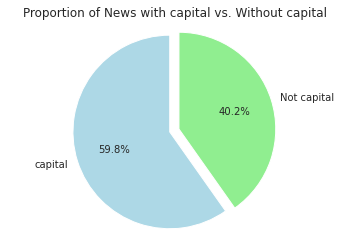

In [ ]:
plot_pie(mcd_, 'capital')

In [ ]:
# Convert the rows into columns for the eqt_code earning date
ead = ead_.assign(one=1) \
          .rename(columns={'earning_date': 'BDATE'}) \
          .set_index(['BDATE', 'eqt_code']) \
          .squeeze() \
          .unstack()

In [ ]:
news_volume = news_volume_.rename(columns={'daclose': 'BDATE'}) \
                         .groupby(['BDATE', 'eqt_code'])['total_count'] \
                         .mean() \
                         .unstack()

In [ ]:
# Normalize the news_volume DataFrame by dividing each element by its corresponding rolling mean
df = news_volume.pipe(
    lambda x: x.div(
        x.rolling(window=126, min_periods=42).mean()  # Calculate the rolling mean for each element
    )
)[['MCD_UN']]

In [ ]:
mcd_['date']=pd.to_datetime(mcd_['date'])

In [ ]:
#shape the earning day dateframe as the same shape as the news_volume rolling average dataframe
df2 =ead.reindex_like(df)

In [ ]:
earning_days = df2.dropna().index.to_list()

In [ ]:
plot_month_bar(mcd_volume, y_col="Count", earning_days=earning_days)

## Get pairwise distances

In [ ]:
d1,d2 = get_pairwise_distance(mcd_, mode="cosine",ncores = 1,method='SentenceTrans')
result1=find_duplicate_indexes(d1,d2,threshold=0.92)
len(result1)

100%|██████████| 1479/1479 [00:01<00:00, 746.85it/s]


1048

In [ ]:
torch.cuda.set_device(1)

In [ ]:
d3,d4=get_pairwise_distance(mcd_, mode="cosine",ncores = 1,method='Laser')
result2=find_duplicate_indexes(d3,d4)
len(result2)

100%|██████████| 1479/1479 [00:02<00:00, 535.23it/s]


896

In [ ]:
result=list(set(result1).intersection(result2))
len(result)

777

In [ ]:
#have a column duplicate which save the duplicate index
mcd_['duplicate'] = mcd_.index.isin(result).astype(int)

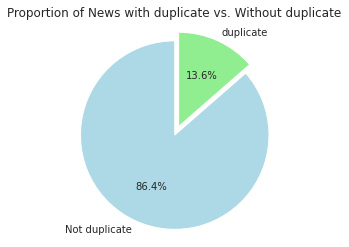

In [ ]:
plot_pie(mcd_, 'duplicate')

In [ ]:
def get_volume(mcd_):
    mcd_volume = mcd_.assign(date=pd.to_datetime(mcd_['date']), \
                         day=mcd_['date'].dt.strftime('%Y-%m-%d')) \
                  .groupby('date').agg(Count=('date', 'size'), duplicate=('duplicate', 'sum'),capital=('capital', 'sum')) \
                  .reset_index().set_index('date')
    return mcd_volume

In [ ]:
mcd_volume=get_volume(mcd_)

In [ ]:
df_average_embedding = mcd_.loc[mcd_['duplicate'] == 0] \
                          .groupby('date')['embeddings'] \
                          .apply(lambda x: np.mean(x, axis=0)) \
                          .reset_index() \
                          .rename(columns={'embeddings': 'embedding_average'})

In [ ]:
df_average_embedding.set_index('date', inplace=True)

In [ ]:
mcd_volume = mcd_volume.reindex(index=df_average_embedding.index).dropna()

Get average embedding for each day

In [ ]:
# df_average_embedding.set_index('date', inplace=True)
# df_average_embedding = df_average_embedding.reindex(index=mcd_volume.index)
# df_average_embedding['embedding_average'].fillna(
#     df_average_embedding.apply(
#         lambda row: mcd_.loc[mcd_['date'] == row.name, 'embeddings'].values[0],
#         axis=1
#     ),
#     inplace=True
# )

Get the standard deviation for each day

In [ ]:
df_average_embedding['average_std'] = mcd_.groupby('date')['embeddings'] \
    .apply(lambda x: round(np.mean(np.std(np.array(x.tolist()), axis=0)), 2))

In [ ]:
# mcd_['cosine_news_average'] = mcd_.apply(
#     lambda row: cosinus_similarity(
#         row['embeddings'],
#         df_average_embedding.loc[row['date'], 'embedding_average']
#     ),
#     axis=1
# )

Get the rolling average

In [ ]:
# Resample the DataFrame with a desired time frequency (e.g., resample every hour)
resampled_df = df_average_embedding['embedding_average'].apply(pd.Series).rolling(window=14,min_periods=5).mean()
df_average_embedding['rolling_embedding_average'] = resampled_df.apply(lambda row: np.array(row.values.tolist()), axis=1)

In [ ]:
df_average_embedding['cosine_similarity'] = df_average_embedding.apply(
    lambda row: cosinus_similarity(row['embedding_average'], df_average_embedding.iloc[df_average_embedding.index.get_loc(row.name) - 1]['embedding_average']) if df_average_embedding.index.get_loc(row.name) > 0 else np.nan,
    axis=1
)

In [ ]:
df_average_embedding['rolling_cosine_similarity'] = df_average_embedding.apply(
    lambda row: cosinus_similarity(row['embedding_average'], df_average_embedding.iloc[df_average_embedding.index.get_loc(row.name) - 1]['rolling_embedding_average']) if df_average_embedding.index.get_loc(row.name) > 0 else np.nan,
    axis=1
)

In [ ]:
columns_to_average = ['cosine_similarity', 'rolling_cosine_similarity','average_std']

df_rolling_cosine = df_average_embedding[columns_to_average].pipe(
    lambda x: x.div(
        x.rolling(window=90, min_periods=10).mean()  # Calculate the rolling mean for each column
    )
)

In [ ]:
df_rolling_volume=mcd_volume.pipe(
    lambda x: x.div(
        x.rolling(window=90, min_periods=10).mean()  # Calculate the rolling mean for each date
    )
)

In [ ]:
df_average_embedding.columns

Index(['embedding_average', 'average_std', 'rolling_embedding_average',
       'cosine_similarity', 'rolling_cosine_similarity'],
      dtype='object')

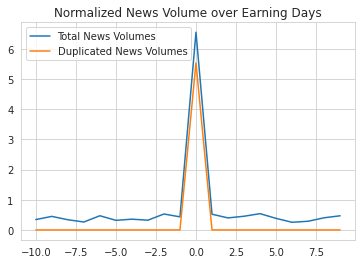

In [ ]:
plot_peak_volume(df_rolling_volume,df2)

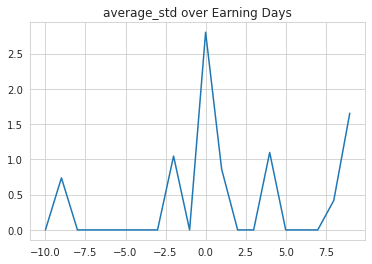

In [ ]:
plot_peak_cosine(df_rolling_cosine, df2, col='average_std')

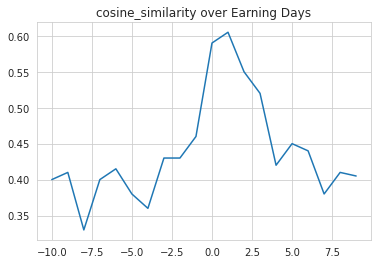

In [ ]:
plot_peak_cosine(df_average_embedding, df2, col='cosine_similarity')

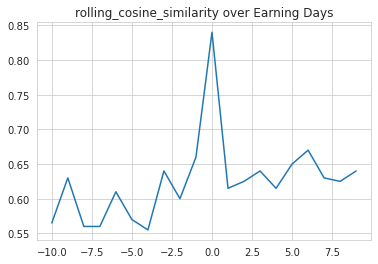

In [ ]:
plot_peak_cosine(df_average_embedding, df2, col='rolling_cosine_similarity')

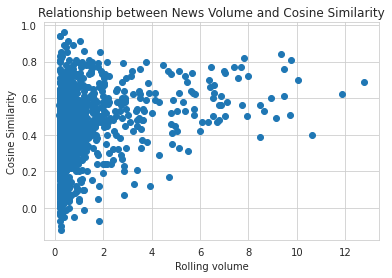

In [ ]:
# create a scatter plot with news volume on the x-axis and cosine similarity on the y-axis
plt.scatter(df_rolling_volume['Count'], df_average_embedding['cosine_similarity'])
# add labels and title
plt.xlabel('Rolling volume')
plt.ylabel('Cosine Similarity')
plt.title('Relationship between News Volume and Cosine Similarity')

# show the plot
plt.show()

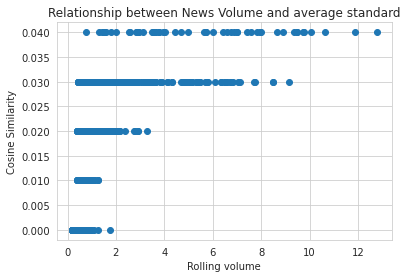

In [ ]:
# create a scatter plot with news volume on the x-axis and cosine similarity on the y-axis
plt.scatter(df_rolling_volume['Count'], df_average_embedding['average_std'])
# add labels and title
plt.xlabel('Rolling volume')
plt.ylabel('Cosine Similarity')
plt.title('Relationship between News Volume and average standard')

# show the plot
plt.show()

News volume over years

In [ ]:
#aggregate the news volume and the duplicated news
mcd_volume_year = mcd_.assign(date=pd.to_datetime(mcd_['date']), \
                         year=mcd_['date'].dt.year) \
                  .groupby('year').agg(Count=('year', 'size'), duplicate=('duplicate', 'sum'),capital=('capital', 'sum')) \
                  .reset_index().set_index('year')

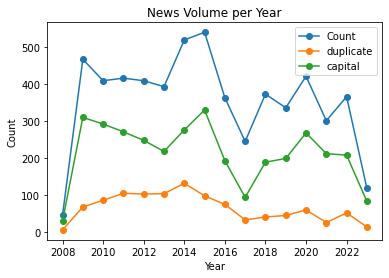

In [ ]:
mcd_volume_year.plot(kind='line', marker='o')
plt.title('News Volume per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

Studying for the year 2015

In [ ]:
def timeseries_boolean(df_volume,df_embedding,index_volume, index_cosine):
    volume_peak_series = pd.Series(False, index=df_volume.index)
    volume_peak_series.loc[index_volume] = True
    cosine_peak_series = pd.Series(False, index=df_volume.index)
    cosine_peak_series.loc[index_cosine] = True

    # Plot the boolean time series for volume peaks
    plt.figure(figsize=(10, 5))
    plt.plot(df_volume.index, volume_peak_series, label='Volume Peaks', color='blue')

    # Plot the boolean time series for cosine similarity peaks
    plt.plot(df_volume.index, cosine_peak_series, label='Cosine Similarity Peaks', color='red')

    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel('Peak Indicator')
    plt.title('Boolean Time Series Plot for Volume and Cosine Similarity Peaks')
    plt.legend()

    # Display the plot
    plt.show()

In [ ]:
def aggregate_date_volume(mcd_,year):
    mcd_=mcd_[mcd_['date'].dt.year == year]
    #aggregate the news volume and the duplicated news
    mcd_volume = mcd_.assign(date=pd.to_datetime(mcd_['date']), \
                            day=mcd_['date'].dt.strftime('%Y-%m-%d')) \
                    .groupby('date').agg(Count=('date', 'size'), duplicate=('duplicate', 'sum')) \
                    .reset_index().set_index('date')
    return mcd_volume

In [ ]:
def get_top_k_indices(df, column, K=20, largest=True):
    if largest:
        top_indices = df[column].nlargest(K).index
    else:
        top_indices = df[column].nsmallest(K).index
    return top_indices

In [ ]:
def analyse_year_top_K(df,df_e,year,K=20):
    df_year_volume=aggregate_date_volume(df,year)
    top_indices_count = get_top_k_indices(df_year_volume, 'Count',K)
    #volume_peak_date=df_year_volume.index[top_indices_count]
    df_e_year=df_e[df_e.index.year == year]
    #df_e_year=df_e_year.set_index('date')
    top_indices_similarity = get_top_k_indices(df_e_year, 'cosine_similarity',K,largest=True)
    top_indices_std = get_top_k_indices(df_e_year, 'average_std',K,largest=True)
    #cosine_peak_date=df_e_year.index[top_indices_similarity]
    top_indices_similarity_rolling = get_top_k_indices(df_e_year, 'rolling_cosine_similarity',K)
    #rolling_cosine_peak_date=df_e_year.index[top_indices_similarity_rolling]
    return df_year_volume,df_e_year,top_indices_count,top_indices_similarity,top_indices_similarity_rolling,top_indices_std

In [ ]:
df_year_volume,df_e_year,top_indices_count,top_indices_similarity,top_indices_similarity_rolling,top_indices_std=analyse_year_top_K(mcd_,df_average_embedding,year=2015,K=20)

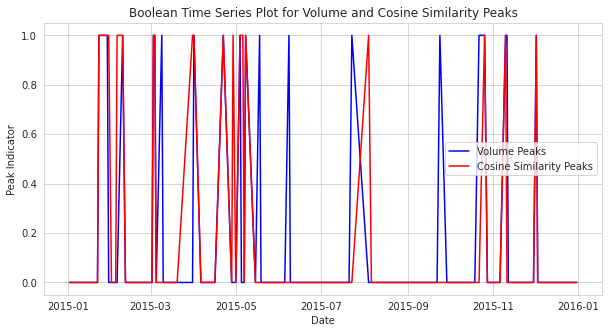

In [ ]:
timeseries_boolean(df_year_volume,df_e_year,top_indices_count, top_indices_std)

In [ ]:
def analyse_year_peak (df,df_e,year):
    df_year_volume=aggregate_date_volume(df,year)
    df_year_volume.plot()
    volume_peak_indices=find_peak(df_year_volume,'Count',year,distance=1)
    volume_peak_date=df_year_volume.index[volume_peak_indices]
    #df_rolling_year_volume=df_rolling_volume.loc[df_rolling_volume.index.year == year]
    #rolling_volume_peak_indices=find_peak(df_rolling_year_volume,'Count',year,distance=0)
    #rolling_volume_peak_date=df_year_volume.index[rolling_volume_peak_indices]
    df_e_year=df_e[df_e.index.year == year]
    #rolling_cosine_peak_indice=find_peak(df_e_year,'rolling_cosine_similarity',year,distance=1)
    #rolling_cosine_peak_date=df_e_year.index[rolling_cosine_peak_indice]
    cosine_peak_indice=find_peak(df_e_year,'cosine_similarity',year,distance=1)
    cosine_peak_date=df_e_year.index[cosine_peak_indice]
    std_peak_indice=find_peak(df_e_year,'average_std',year,distance=1)
    std_peak_date=df_e_year.index[std_peak_indice]
    #timeseries_boolean(df_year_volume,df_e_year,rolling_volume_peak_indices, rolling_cosine_peak_indice)
    timeseries_boolean(df_year_volume,df_e_year,volume_peak_date, cosine_peak_date)
    timeseries_boolean(df_year_volume,df_e_year,volume_peak_date, std_peak_date)
    return df_year_volume,volume_peak_date,std_peak_date,cosine_peak_date

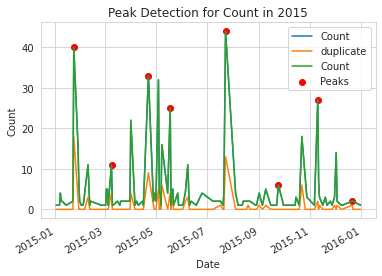

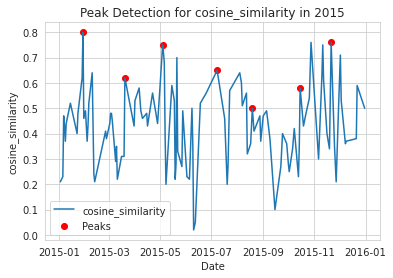

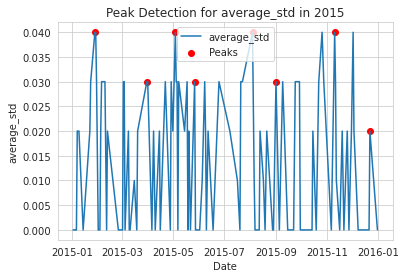

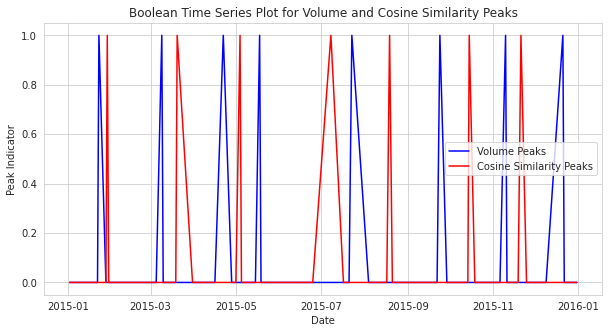

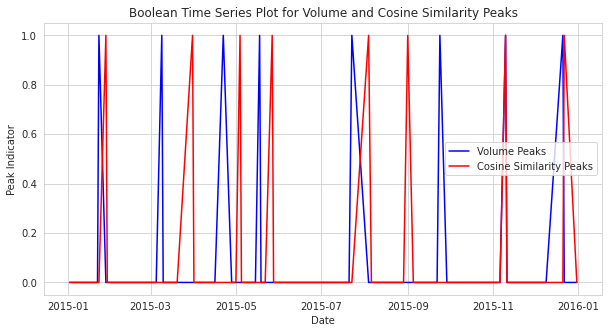

In [ ]:
df_year_volume,volume_peak_date,rolling_cosine_peak_date,cosine_peak_date=analyse_year_peak(mcd_,df_average_embedding,year=2015)

<Figure size 576x432 with 0 Axes>

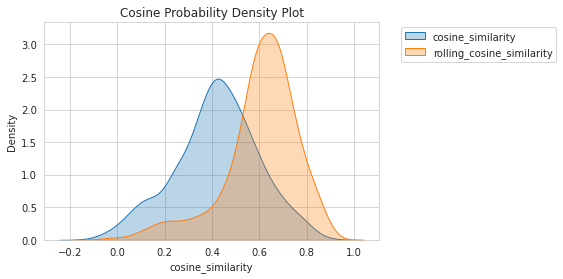

In [ ]:
# assuming your dataframe is called result_df and the delay columns are already calculated

similarity_cols = ['cosine_similarity','rolling_cosine_similarity']
# set seaborn style
sns.set_style('whitegrid')
# create a larger figure for the plot
fig = plt.figure(figsize=(8, 6))
# create a subplot for the plot
fig, ax = plt.subplots()

# loop over the delay columns and plot each one
for col in similarity_cols:
    sns.kdeplot(df_average_embedding[col], ax=ax, label=col, fill=True, alpha=0.3)

# set the y-axis limits and ticks
#ax.set_ylim([0, 0.14])
#ax.set_yticks([i/10 for i in range(0, 15, 2)])

# add a title and legend to the plot
ax.set_title('Cosine Probability Density Plot')
ax.legend()
# move the legend outside the plot and adjust its position
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# show the plot
plt.show()

## Study of the earning days

In [ ]:
mcd_earning=mcd_.loc[mcd_['date'].isin(earning_days)]
mcd_non_earning = mcd_.loc[~mcd_['date'].isin(earning_days)]

In [ ]:
volume_non_earning=get_volume(mcd_non_earning)
volume_earning=get_volume(mcd_earning)

In [ ]:
volume_non_earning=volume_non_earning.resample('B').sum()
volume_non_earning=volume_non_earning.loc[~volume_non_earning.index.isin(earning_days)]

<Figure size 576x432 with 0 Axes>

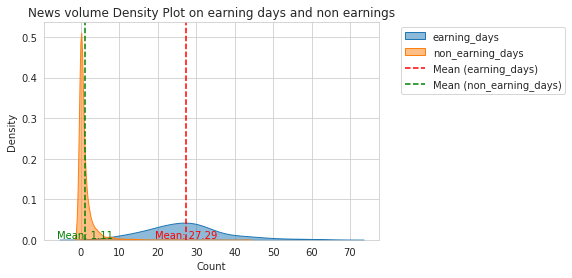

In [ ]:
sns.set_style('whitegrid')
# create a larger figure for the plot
fig = plt.figure(figsize=(8, 6))
# create a subplot for the plot
fig, ax = plt.subplots()
col = 'Count'
sns.kdeplot(volume_earning[col], ax=ax, label='earning_days', fill=True, alpha=0.5)
#sns.kdeplot(volume_earning['capital'], ax=ax, label='earning_days_capital', fill=True, alpha=0.5)
sns.kdeplot(volume_non_earning[col], ax=ax, label='non_earning_days', fill=True, alpha=0.5)
#sns.kdeplot(volume_non_earning['capital'], ax=ax, label='non_earning_days_capital', fill=True, alpha=0.5)

# Calculate the mean values
mean_earning = volume_earning[col].mean()
mean_non_earning = volume_non_earning[col].mean()

# Plot vertical lines for the mean values
ax.axvline(mean_earning, color='r', linestyle='--', label='Mean (earning_days)')
ax.axvline(mean_non_earning, color='g', linestyle='--', label='Mean (non_earning_days)')

# Add text for the mean values
ax.text(mean_earning, 0.005, f'Mean: {mean_earning:.2f}', color='r', ha='center')
ax.text(mean_non_earning, 0.005, f'Mean: {mean_non_earning:.2f}', color='g', ha='center')

ax.set_title('News volume Density Plot on earning days and non earnings')
ax.legend()
# move the legend outside the plot and adjust its position
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# show the plot
plt.show()

## Study of the earning days

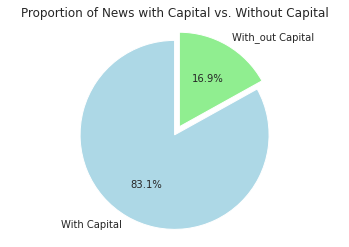

In [ ]:
import matplotlib.pyplot as plt

# Count the number of news with capital and without capital
capital_counts = mcd_earning['capital'].value_counts()

# Create a pie chart
labels = ['With Capital', 'With_out Capital']
sizes = capital_counts.values
colors = ['lightblue', 'lightgreen']
explode = (0.1, 0)  # explode the first slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Proportion of News with Capital vs. Without Capital')

# Display the chart
plt.show()

In [ ]:
headlines=mcd_earning['headline']

In [ ]:
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)

After ignoring terms that appear in more than 50% of the documents (as set by max_df=0.5) and terms that are not present in at least 5 documents (set by min_df=5), the resulting number of unique terms n_features is around 330. We can additionally quantify the sparsity of the X_tfidf matrix as the fraction of non-zero entries devided by the total number of elements.

In [ ]:
X_tfidf = vectorizer.fit_transform(headlines)
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

n_samples: 1583, n_features: 330


In [ ]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

0.013


Define the number of clusters

In [ ]:
earning_embeddings=mcd_earning['embeddings']
earning_embeddings = list(earning_embeddings) /  np.linalg.norm(list(earning_embeddings), axis=1, keepdims=True)

In [ ]:
non_earning_embeddings=mcd_non_earning['embeddings']
non_earning_embeddings = list(non_earning_embeddings) /  np.linalg.norm(list(non_earning_embeddings), axis=1, keepdims=True)

In [ ]:
embeddings=mcd_['embeddings']
embeddings = list(embeddings) /  np.linalg.norm(list(embeddings), axis=1, keepdims=True)

In [ ]:
import numba

numba.__version__

'0.50.1'

In [ ]:
!pip install hdbscan

  Using cached hdbscan-0.8.29.tar.gz (5.2 MB)
  Installing build dependencies ... /^C
anceled
ERROR: Operation cancelled by user


In [ ]:
import umap

In [ ]:
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      random_state = None):
    """
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
    """
    
    umap_embeddings = (umap.UMAP(n_neighbors=n_neighbors, 
                                n_components=n_components, 
                                metric='cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               metric='euclidean', 
                               cluster_selection_method='eom').fit(umap_embeddings)

    return clusters

In [ ]:
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given cluster supplied from running hdbscan
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

HDBSCAN+UMAP

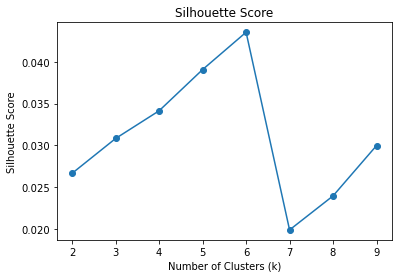

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn import metrics
from time import time
from sklearn.cluster import KMeans

# Calculate silhouette scores for different k values
silhouette_scores = []
k_values = range(2, 10)  # Try different values of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(non_earning_embeddings)
    silhouette_scores.append(silhouette_score(non_earning_embeddings, kmeans.labels_))

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()


In [ ]:
true_k=7

In [ ]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

In [ ]:
# Fit the KMeans model to the TF-IDF features
kmeans.fit(list(earning_embeddings))

# Get the cluster labels
cluster_labels = kmeans.labels_

In [ ]:
mcd_earning['cluster'] = cluster_labels

/opt/tmp/tmp/ipykernel_183717/667756254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcd_earning['cluster'] = cluster_labels


In [ ]:
with open('/mnt/research-live/user/yzhong/MCD_UN_earning days.txt', 'w') as f:
    for row in mcd_earning.itertuples():
        f.write(str(row.last_update) + '\n')
        f.write(f'Cluster: {row.cluster}        {str(row.headline)}' + '\n')

In [ ]:
import nltk
import wordcloud
stopwords = set(wordcloud.STOPWORDS) #| set(nltk.corpus.stopwords.words("english"))
stopwords.update(["br", "href",'MCDONALD','S',"MCD",'WILL','MCDONALDS'])

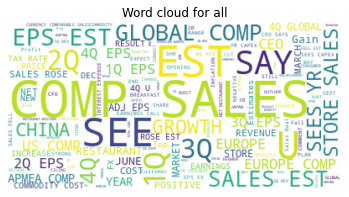

In [ ]:
from wordcloud import WordCloud
#cluster_0 = mcd_earning[mcd_earning['cluster'] == 0]
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(' '.join(mcd_earning['headline'].dropna()))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word cloud for all')
plt.axis("off")
plt.show()

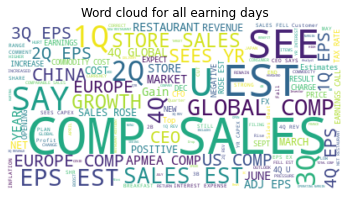

In [ ]:
from wordcloud import WordCloud
#cluster_0 = mcd_earning[mcd_earning['cluster'] == 0]
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(' '.join(mcd_earning['headline'].dropna()))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word cloud for all earning days')
plt.axis("off")
plt.show()

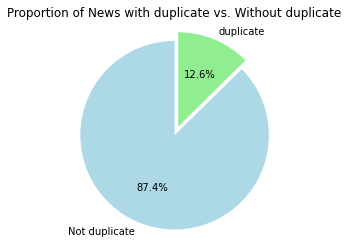

In [ ]:
plot_pie(mcd_earning,'duplicate')

In [ ]:
def is_blank_string(value):
    return value.strip() == ''

In [ ]:
type(mcd_earning.iloc[72]['body'])

str

In [ ]:
earning_capital=mcd_[mcd_['capital']==1]

In [ ]:
earning_no_capital=mcd_[mcd_['capital']==0]

In [ ]:
mcd_earning[mcd_earning['capital']==1]['body'].apply(is_blank_string).value_counts()

False    666
True     649
Name: body, dtype: int64

In [ ]:
earning_no_capital['body'].apply(is_blank_string).value_counts()

False    2142
True      159
Name: body, dtype: int64

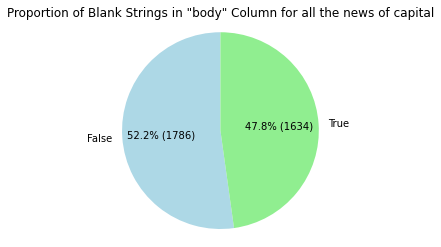

In [ ]:
import matplotlib.pyplot as plt

counts = earning_capital['body'].apply(is_blank_string).value_counts()

labels = counts.index
sizes = counts.values
colors = ['lightblue', 'lightgreen']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct=lambda pct: f"{pct:.1f}% ({int(pct/100.*sum(sizes))})",
       startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
ax.set_title('Proportion of Blank Strings in "body" Column for all the news of capital')

plt.show()

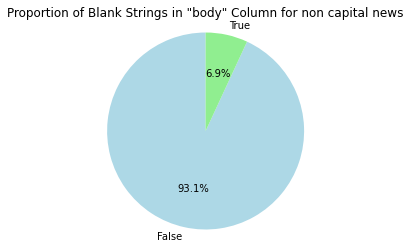

In [ ]:
import matplotlib.pyplot as plt

counts = earning_no_capital['body'].apply(is_blank_string).value_counts()

labels = counts.index
sizes = counts.values
colors = ['lightblue', 'lightgreen']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Proportion of Blank Strings in "body" Column for non capital news')

plt.show()


In [164]:
import nltk
from nltk.corpus import stopwords
from collections import Counter

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Get the stop words
stop_words = set(stopwords.words('english'))

# Create a list to store the words
words = []

# Iterate over the "body" column and tokenize the text
for text in earning_capital[~earning_capital['body'].apply(is_blank_string)]['body']:
    tokens = nltk.word_tokenize(text.lower())
    # Filter out stop words and non-alphabetic words
    words += [word for word in tokens if word.isalpha() and word not in stop_words]

# Count the frequency of words
word_counts = Counter(words)

# Get the top 10 most frequent words
top_10_words = word_counts.most_common(10)

# Print the top 10 words and their frequencies
for word, count in top_10_words:
    print(f"{word}: {count}")


[nltk_data] Downloading package stopwords to /home/yzhong/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/home/yzhong/nltk_data'
    - '/home/yzhong/conda/envs/yihan_gpu/nltk_data'
    - '/home/yzhong/conda/envs/yihan_gpu/share/nltk_data'
    - '/home/yzhong/conda/envs/yihan_gpu/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


: 

In [ ]:
earning_capital[~earning_capital['body'].apply(is_blank_string)]['body']

1       PR Newswire: U.S. press release is accessible ...
2       PR Newswire: U.S. press release is accessible ...
3       PR Newswire: U.S. press release is accessible ...
4       PR Newswire: U.S. press release is accessible ...
5       PR Newswire: U.S. press release is accessible ...
                              ...                        
5677    Tokyo Stock Exchange press release is accessib...
5679    PR Newswire press release is accessible throug...
5684    PR Newswire press release is accessible throug...
5691    Tokyo Stock Exchange press release is accessib...
5721    Tokyo Stock Exchange press release is accessib...
Name: body, Length: 1786, dtype: object

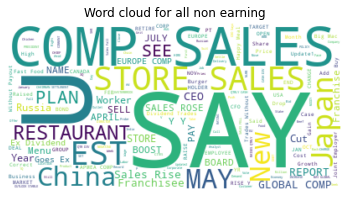

In [ ]:
from wordcloud import WordCloud
#cluster_0 = mcd_earning[mcd_earning['cluster'] == 0]
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(' '.join(mcd_non_earning['headline'].dropna()))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word cloud for all non earning')
plt.axis("off")
plt.show()

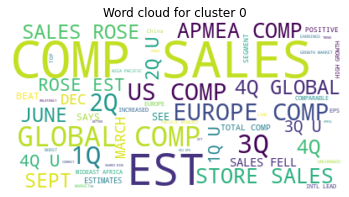

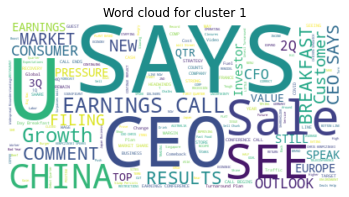

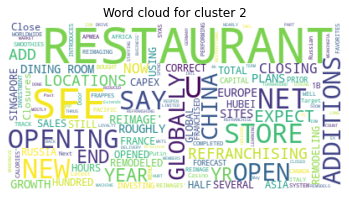

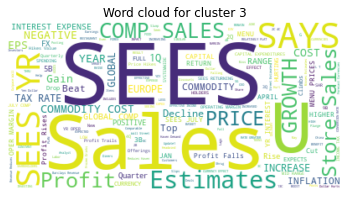

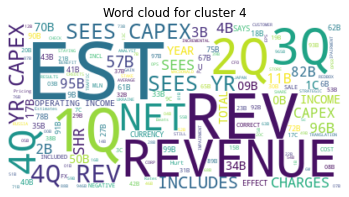

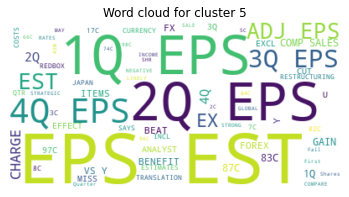

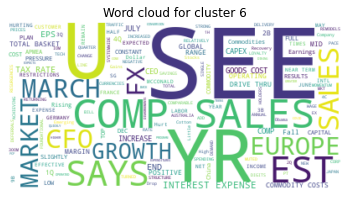

In [ ]:
for cluster_num in range(7):
    cluster_data = mcd_earning[mcd_earning['cluster'] == cluster_num]
    wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(' '.join(cluster_data['headline'].dropna()))

    # Plot the word cloud
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f'Word cloud for cluster {cluster_num}')
    plt.axis("off")
    plt.show()

calculate the proportion of each label clusters. 

In [ ]:
# Fit the KMeans model to the TF-IDF features
kmeans.fit(X_lsa)

# Get the cluster labels
cluster_labels = kmeans.labels_

In [ ]:
cluster_labels

array([3, 3, 0, ..., 6, 0, 0], dtype=int32)

In [ ]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

In [ ]:
for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: mcd earnings sales profit estimates ceo growth china results new 
Cluster 1: comp mcdonalds sales est apmea sept june dec march europe 
Cluster 2: sales comp est global 3q 4q 1q 2q europe store 
Cluster 3: eps est 4q 3q 1q rev revenue adj ex 23 
Cluster 4: 2q eps est rev revenue adj 38 40 currency net 
Cluster 5: sees yr mcd mcdonalds capex restaurants commodity year costs expense 
Cluster 6: says market ceo china sales mcd prices 1q breakfast europe 


In [ ]:
top_indices_similar=get_top_k_indices(df_average_embedding, 'cosine_similarity', K=30, largest=True)

In [ ]:
top_indices_count=get_top_k_indices(volume_non_earning, 'Count', K=30, largest=True)

In [ ]:
df_peak_volume = pd.DataFrame(index=df2.index, columns=df2.columns) \
                    .fillna(np.nan) 
df_peak_volume.loc[top_indices_count] = 1

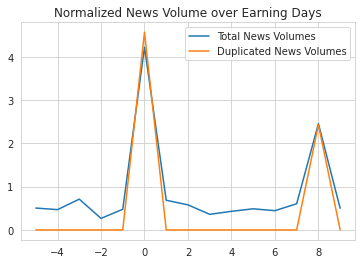

In [ ]:
plot_peak_volume(df_rolling_volume,df_peak_volume)

In [ ]:
df_average_embedding.columns

Index(['embedding_average', 'news_average_cosine_similarity',
       'news_average_cosine_similarity_remove_duplicates',
       'rolling_embedding_average', 'cosine_similarity',
       'rolling_cosine_similarity', 'cosine_similarity_t_5_average'],
      dtype='object')

In [ ]:
df_rolling_cosine.columns

Index(['cosine_similarity', 'news_average_cosine_similarity',
       'rolling_cosine_similarity',
       'news_average_cosine_similarity_remove_duplicates'],
      dtype='object')

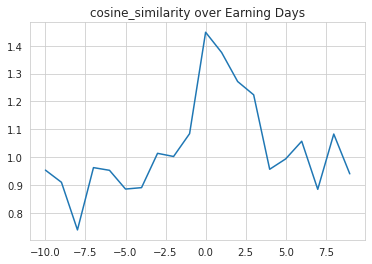

In [ ]:
plot_peak_cosine(df_rolling_cosine,df2,col='cosine_similarity')

In [ ]:
with open('/mnt/research-live/user/yzhong/MCD_UN_earning days.txt', 'w') as f:
    for row in mcd_earning.itertuples():
        f.write(str(row.last_update) + '\n')
        f.write(str(row.headline) + '\n')

In [ ]:
top_indices_not_similar=get_top_k_indices(df_average_embedding, 'cosine_similarity', K=30, largest=False)

In [ ]:
df_average_embedding=df_average_embedding.set_index('date')

In [ ]:
top_indices_not_similar=get_top_k_indices(df_average_embedding, 'cosine_similarity', K=30, largest=False)

In [ ]:
workdays = pd.bdate_range(start=pd.to_datetime('2008-11-10'), periods=5)[1:5]
workdays

DatetimeIndex(['2008-11-11', '2008-11-12', '2008-11-13', '2008-11-14'], dtype='datetime64[ns]', freq='B')

In [ ]:
def calculate_average(df, date):
    # Get the workdays for the five days after the specified date
    workdays = pd.bdate_range(start=date, periods=3)[1:3]

    # Filter the DataFrame to include only the workdays that exist in the index
    workday_df = df[df.index.isin(workdays)]

    # Calculate the average of the cosine_similarity column
    average = workday_df['cosine_similarity'].mean()

    return average

# Apply the function to each date and store the result in a new column
df_average_embedding['cosine_similarity_t_5_average'] = df_average_embedding.index.map(
    lambda date: calculate_average(df_average_embedding, date)
)

In [ ]:
df_average_embedding.loc[pd.to_datetime('2015-03-16')]

embedding_average                                   [-0.03709726221859455, -0.016740650447900407, ...
news_average_cosine_similarity                                                                   0.96
news_average_cosine_similarity_remove_duplicates                                                 0.96
rolling_embedding_average                           [-0.007078066917558075, -0.017314813626788723,...
cosine_similarity                                                                               -0.05
rolling_cosine_similarity                                                                        0.11
cosine_similarity_t_5_average                                                                    0.37
Name: 2015-03-16 00:00:00, dtype: object

In [ ]:
def find_peaks_low(df, col, threshold=0.5, distance=10):
    """
    Find indices of peaks and lows in a time series based on a threshold value.
    
    Args:
        df (DataFrame): Input DataFrame with datetime index.
        col (str): Name of the column containing the time series data.
        threshold (float): Threshold value for identifying lows.
        distance (int): Minimum distance between peaks or lows.
    
    Returns:
        peak_indices (array): Indices of detected peaks.
        low_indices (array): Indices of detected lows.
    """
    data = df[col].to_numpy()
    
    # Use scipy's find_peaks to detect peak indices
    peak_indices, _ = find_peaks(data, distance=distance)
    
    # Find indices where the data is lower than the threshold value
    low_indices = np.where(data < threshold)[0]
    
    # Plot the time series with identified peaks and lows
    plt.plot(df.index, data, label=col)
    plt.scatter(df.index[peak_indices], data[peak_indices], color='red', label='Peaks')
    plt.scatter(df.index[low_indices], data[low_indices], color='green', label='Lows')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.title('Peak and Low Detection')
    plt.legend()
    plt.show()
    
    return peak_indices, low_indices

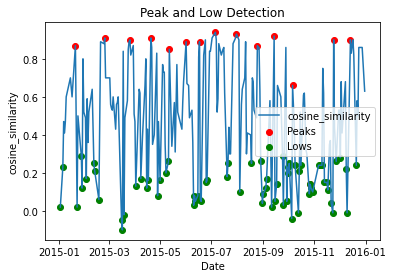

In [ ]:
df_average_embedding_2015 = df_average_embedding[df_average_embedding['date'].dt.year == 2015]
df_average_embedding_2015 = df_average_embedding_2015.set_index('date')
cosine_peak_indices_, cosine_low_indices_ = find_peaks_low(df_average_embedding_2015, 'cosine_similarity', threshold=0.3, distance=10)

In [ ]:
volume_peak_series = pd.Series(False, index=mcd_2015_volume.index)
volume_peak_series.loc[mcd_2015_volume.index[volume_peak_indices]] = True

In [ ]:
peak_diff = abs(np.diff(mcd_2015_volume['Count'].to_numpy()))

In [ ]:
np.median(peak_diff)

1.0

In [ ]:
peak_diff

array([ 0,  0,  4,  2,  0,  1,  1,  0,  1, 39, 40, 16,  9,  5,  2,  0,  1,
        0,  2,  8, 11,  1,  1,  0,  0,  0,  1,  0,  0,  4,  0,  4,  1, 11,
       10,  0,  1,  1,  1,  0,  0,  2,  2,  0,  0,  0,  0,  0,  2, 20, 22,
        1,  1,  1,  0,  1,  0,  1,  1,  0,  0,  0, 33, 33,  0,  1,  3,  4,
        1, 31, 28,  0,  4, 15, 15,  0,  4, 20, 23,  3,  1,  4,  3,  3,  1,
        0,  1,  1,  4,  6,  6,  4,  0,  1,  1,  0,  0,  0,  0,  0,  0,  3,
        3,  0,  0,  0,  0,  0,  2,  2,  0,  0,  0,  0,  2,  2,  4,  4, 44,
       44,  0,  0,  0,  0,  3,  1,  1,  1,  0,  0,  2,  1,  1,  2,  2,  2,
        2,  0,  0,  0,  1,  1,  0,  3,  3,  0,  4,  4,  0,  0,  1,  1,  1,
        4,  5,  0,  1,  0,  1,  0,  0,  1,  1,  0,  0,  1,  1,  2,  1,  1,
       18, 18,  7,  7,  2,  2,  0,  0, 26, 20,  4,  2,  0,  0,  3,  3,  0,
        0,  0,  2,  2,  3,  3, 14, 12,  2,  1,  1,  0,  0,  0,  0,  0,  0,
        1,  1,  2,  0,  0,  1])

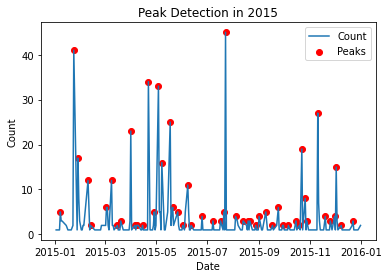

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def detect_peaks(data, min_distance=None):
    # Calculate the differences between consecutive peak indices
    peak_diff = abs(np.diff(data))
    
    # Use the median difference as the default minimum distance
    if min_distance is None:
        min_distance = int(np.median(peak_diff))
    
    # Use scipy's find_peaks with the calculated minimum distance
    peak_indices, _ = find_peaks(data, distance=min_distance)
    
    return peak_indices

# Assuming your DataFrame is named "mcd_2015_volume"
# Convert the "Count" column to a NumPy array
counts = mcd_2015_volume['Count'].to_numpy()

# Detect peaks with the method
peak_indices = detect_peaks(counts)

# Plot the time series with identified peaks
plt.plot(mcd_2015_volume.index, counts, label='Count')
plt.scatter(mcd_2015_volume.index[peak_indices], counts[peak_indices], color='red', label='Peaks')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Peak Detection in 2015')
plt.legend()
plt.show()


## Case study for a day of peak

Find a way to weight the news

verify if the peak of the cosine similarity is similar to the peak of news volumes 

In [ ]:
mcd_volume.loc[earning_days].sort_values